# KTRX Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.ktrlite import KTRLiteMAP
from orbit.models.ktrx import KTRXFull, KTRXAggregated

from orbit.estimators.pyro_estimator import PyroEstimatorVI
from orbit.estimators.stan_estimator import StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components, plot_ktr_lev_knots
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

%matplotlib inline

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
df = load_iclaims()
date_col = 'week'
response_col = 'claims'

print(df.shape)
df.head()

(443, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.21988,-0.31845,0.11750,-0.41763,0.12265
1,2010-01-10,13.62422,0.21988,-0.19484,0.16879,-0.42548,0.11044
2,2010-01-17,13.39874,0.23614,-0.29248,0.11750,-0.46523,0.53234
3,2010-01-24,13.13755,0.20335,-0.19484,0.10692,-0.48175,0.42864
4,2010-01-31,13.19676,0.13436,-0.24247,0.07448,-0.48893,0.48740


In [5]:
print(f'starts with {df[date_col].min()}\nends with {df[date_col].max()}\nshape: {df.shape}')

starts with 2010-01-03 00:00:00
ends with 2018-06-24 00:00:00
shape: (443, 7)


In [6]:
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

## KTRLite

In [7]:
# level_knot_dates = pd.date_range(start='1981-01-01', end='1990-12-31', periods=21)
# level_knot_dates

In [8]:
ktrlite = KTRLiteMAP(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    span_level=.05,
    # level_knot_dates=level_knot_dates,
    # date_freq='D',
    span_coefficients=.3,
    estimator_type=StanEstimatorMAP,
    n_bootstrap_draws=1e4,
)

In [9]:
ktrlite.fit(train_df)

In [10]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_52_5,seasonality_52,seasonality_52_95
0,2017-07-02,12.21151,12.35675,12.50032,12.35965,12.37136,12.38287,-0.01467,-0.01467,-0.01467
1,2017-07-09,12.20413,12.35403,12.50467,12.34788,12.37129,12.39431,-0.01740,-0.01740,-0.01740
2,2017-07-16,12.19514,12.34744,12.49516,12.33610,12.37122,12.40576,-0.02398,-0.02398,-0.02398
3,2017-07-23,12.18443,12.33659,12.48785,12.32433,12.37115,12.41720,-0.03484,-0.03484,-0.03484
4,2017-07-30,12.16159,12.32134,12.48069,12.31255,12.37108,12.42864,-0.05009,-0.05009,-0.05009


In [11]:
'{:.2%}'.format(smape(predicted_df['prediction'].values, test_df[response_col].values))

'0.75%'

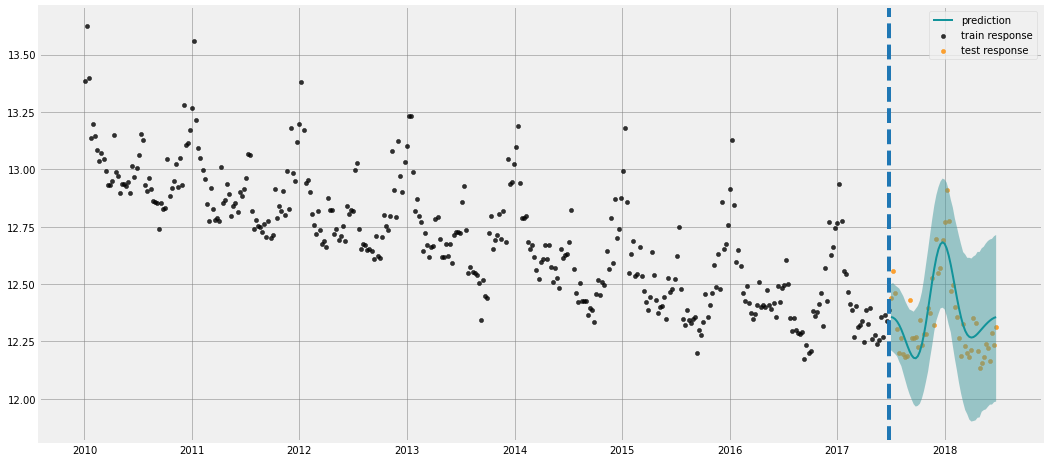

In [12]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col, 
                        test_actual_df=test_df)

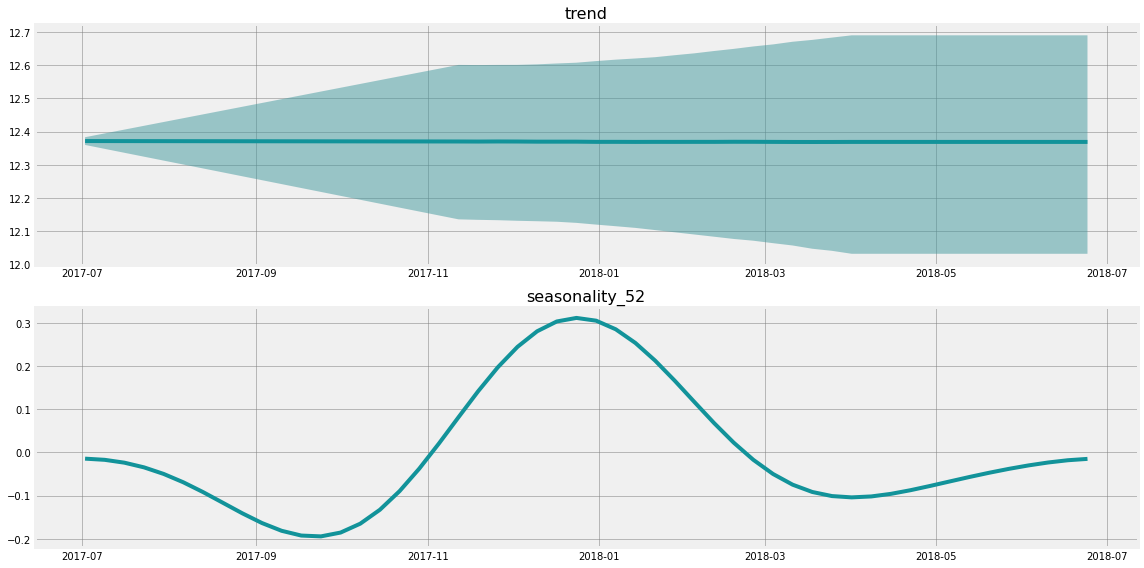

In [13]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col, 
                              plot_components=['trend', 'seasonality_52'])

In [14]:
# get the knots
lev_knots = ktrlite._aggregate_posteriors['map']['lev_knot']
decomp_df = ktrlite.predict(df=train_df, decompose=True)

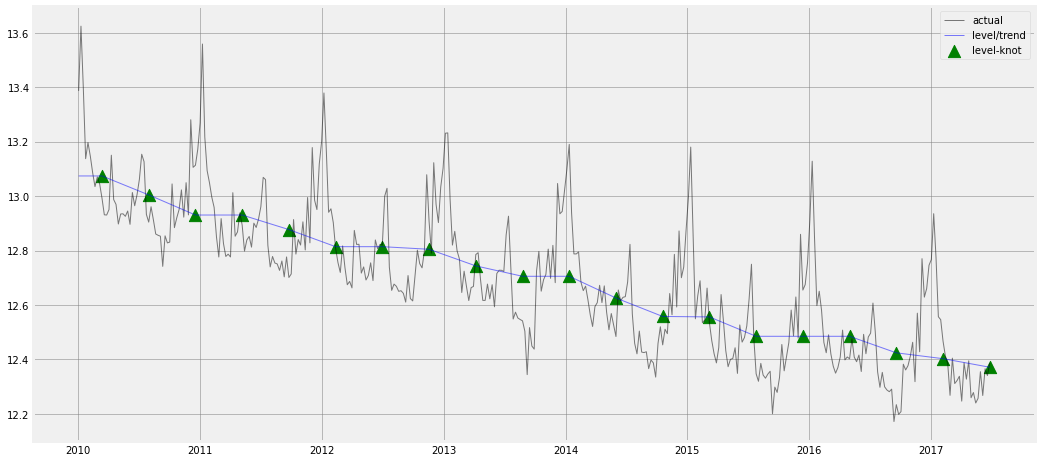

In [15]:
_ = plot_ktr_lev_knots(train_df, decomp_df, date_col, response_col, ktrlite._level_knot_dates, lev_knots)

## KTRX

In [16]:
# prepare the input
level_knot_dates = ktrlite._level_knot_dates
level_knots = ktrlite._aggregate_posteriors['map']['lev_knot'][0]
seasonal_knots_input = {
    '_seas_coef_knot_dates': ktrlite._coef_knot_dates,
    '_sea_coef_knot': ktrlite._aggregate_posteriors['map']['coef_knot'],
    '_seasonality': ktrlite._seasonality,
    '_seasonality_fs_order': ktrlite._seasonality_fs_order,
}

In [17]:
ktrx = KTRXAggregated(
    response_col=response_col,
    date_col=date_col,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots,
    seasonal_knots_input=seasonal_knots_input,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    level_knot_scale=.1, #.01
    span_coefficients=0.3,
    rho_coefficients=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    #learning_rate_total_decay=0.05,
    verbose=True,
    message=100,
    aggregate_method="median",
    estimator_type=PyroEstimatorVI,
)

ktrx.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 225.23, scale = 0.087627
step  100 loss = -282.2, scale = 0.12923
step  200 loss = -290.8, scale = 0.1234
step  300 loss = -278.39, scale = 0.12657
step  400 loss = -295.71, scale = 0.11762
step  500 loss = -290.72, scale = 0.12251
step  600 loss = -294.43, scale = 0.13251
step  700 loss = -275.73, scale = 0.137
step  800 loss = -297.61, scale = 0.1355
step  900 loss = -293.66, scale = 0.13748


In [18]:
# ktrx = KTRXFull(
#     response_col=response_col,
#     date_col=date_col,
#     level_knot_dates=level_knot_dates,
#     level_knots=level_knots,
#     seasonal_knots_input=seasonal_knots_input,
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
#     level_knot_scale=.1, #.01
#     span_coefficients=0.3,
#     rho_coefficients=0.15,
#     # pyro optimization parameters
#     seed=8888,
#     num_steps=1000,
#     num_sample=1000,
#     learning_rate=0.1,
#     #learning_rate_total_decay=0.05,
#     verbose=True,
#     message=100,
#     estimator_type=PyroEstimatorVI,
# )

# ktrx.fit(train_df)

In [19]:
coef_df = ktrx.get_regression_coefs(coefficient_method="smooth") # include_ci=True
print(coef_df.head())
print(coef_df.tail())

        week  trend.unemploy  trend.filling  trend.job
0 2010-01-03         0.08489        0.18806    0.32625
1 2010-01-10         0.08488        0.18806    0.32624
2 2010-01-17         0.08487        0.18805    0.32623
3 2010-01-24         0.08486        0.18805    0.32622
4 2010-01-31         0.08485        0.18805    0.32622
          week  trend.unemploy  trend.filling  trend.job
386 2017-05-28         0.09473        0.19479    0.32508
387 2017-06-04         0.09475        0.19479    0.32509
388 2017-06-11         0.09476        0.19480    0.32510
389 2017-06-18         0.09477        0.19480    0.32510
390 2017-06-25         0.09479        0.19481    0.32511


In [20]:
coef_df = ktrx.get_regression_coefs(coefficient_method="empirical") # include_ci=True
print(coef_df.head())
print(coef_df.tail())

        week  trend.unemploy  trend.filling  trend.job
0 2010-01-03         0.08476        0.18798    0.32630
1 2010-01-10         0.08475        0.18799    0.32630
2 2010-01-17         0.08473        0.18799    0.32630
3 2010-01-24         0.08471        0.18800    0.32630
4 2010-01-31         0.08470        0.18800    0.32630
          week  trend.unemploy  trend.filling  trend.job
386 2017-05-28         0.09528        0.19476    0.32554
387 2017-06-04         0.09527        0.19476    0.32553
388 2017-06-11         0.09525        0.19476    0.32552
389 2017-06-18         0.09524        0.19476    0.32551
390 2017-06-25         0.09522        0.19476    0.32550


In [21]:
coef_df = ktrx.get_regression_coefs(coefficient_method="smooth" ,
                                    date_array=['2017-06-11', '2017-06-18', '2017-06-25',
                                                '2017-07-02', '2017-07-09', '2017-07-16']) 
coef_df

,week,trend.unemploy,trend.filling,trend.job
0,2017-06-11,0.09476,0.19480,0.32510
1,2017-06-18,0.09477,0.19480,0.32510
2,2017-06-25,0.09479,0.19481,0.32511
3,2017-07-02,0.09479,0.19481,0.32511
4,2017-07-09,0.09479,0.19481,0.32511
5,2017-07-16,0.09479,0.19481,0.32511


In [24]:
coef_df = ktrx.get_regression_coefs(coefficient_method="empirical" ,
                                    date_array=['2017-06-11', '2017-06-18', '2017-06-25',
                                                '2017-07-02', '2017-07-09', '2017-07-16']) 
coef_df

,week,trend.unemploy,trend.filling,trend.job
0,2017-06-11,0.09525,0.19476,0.32552
1,2017-06-18,0.09524,0.19476,0.32551
2,2017-06-25,0.09522,0.19476,0.32550
3,2017-07-02,0.09522,0.19476,0.32550
4,2017-07-09,0.09522,0.19476,0.32550
5,2017-07-16,0.09522,0.19476,0.32550


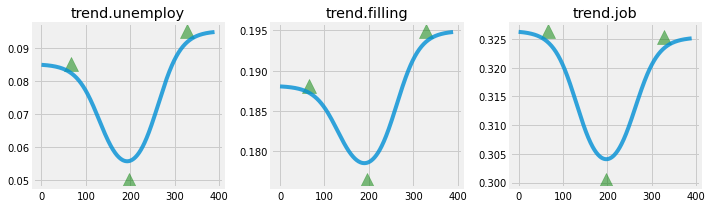

In [25]:
_ = ktrx.plot_regression_coefs(with_knot=True, coefficient_method='smooth', ncol=3, figsize=(10, 3))

In [32]:
predicted_df = ktrx.predict(df=test_df, coefficient_method="smooth", decompose=False)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.08625,12.30897,12.53636
1,2017-07-09,12.10477,12.33088,12.55880
2,2017-07-16,12.08444,12.31376,12.54615
3,2017-07-23,12.07804,12.30561,12.53697
4,2017-07-30,12.06620,12.30294,12.53334


In [27]:
predicted_df = ktrx.predict(df=test_df, coefficient_method="empirical", decompose=False)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.08637,12.30903,12.52946
1,2017-07-09,12.11148,12.33100,12.55632
2,2017-07-16,12.08867,12.31384,12.53713
3,2017-07-23,12.07857,12.30569,12.53613
4,2017-07-30,12.07471,12.30304,12.53852


In [33]:
'{:.2%}'.format(smape(predicted_df['prediction'].values, test_df[response_col].values))

'0.73%'

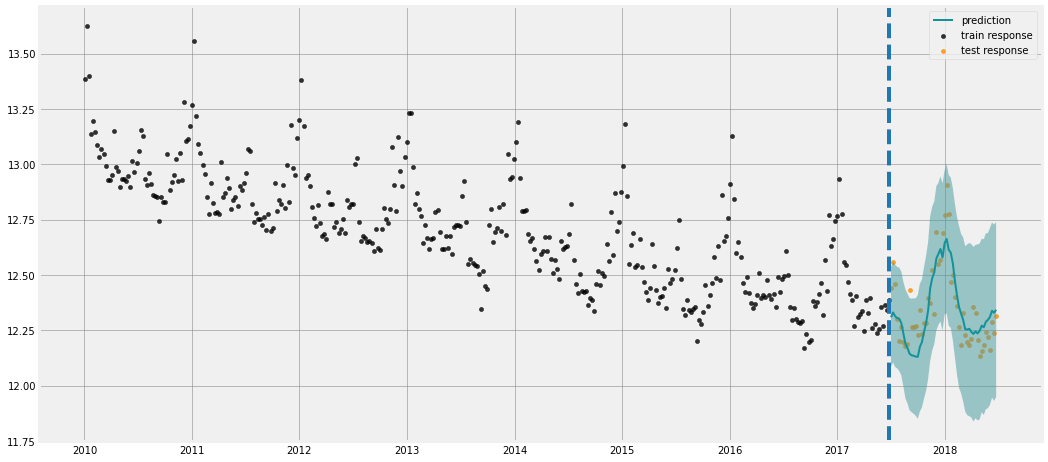

In [34]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col, 
                    test_actual_df=test_df)

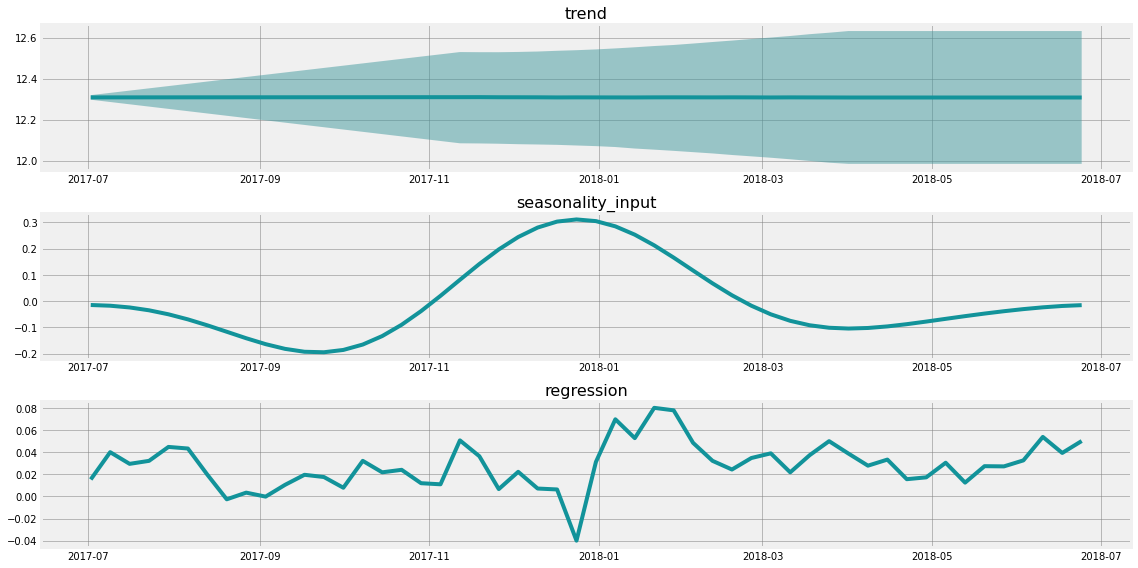

In [31]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col, 
                          plot_components=['trend', 
                                           'seasonality_input',
                                           'regression'])

## Try a different data

In [25]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()
df['electricity'] = np.log(df['electricity'])

date_col = 'date'
response_col = 'electricity'

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [26]:
test_size = 365
train_df = df[:-test_size]
test_df = df[-test_size:]

In [27]:
ktrlite = KTRLiteMAP(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    span_level=.05,
    # level_knot_dates=level_knot_dates,
    # date_freq='D',
    span_coefficients=.3,
    estimator_type=StanEstimatorMAP,
    n_bootstrap_draws=1e4,
)

ktrlite.fit(train_df)

In [28]:
# prepare the input
level_knot_dates = ktrlite._level_knot_dates
level_knots = ktrlite._aggregate_posteriors['map']['lev_knot'][0]
seasonal_knots_input = {
    '_seas_coef_knot_dates': ktrlite._coef_knot_dates,
    '_sea_coef_knot': ktrlite._aggregate_posteriors['map']['coef_knot'],
    '_seasonality': ktrlite._seasonality,
    '_seasonality_fs_order': ktrlite._seasonality_fs_order,
}

In [29]:
ktrx = KTRXFull(
    response_col=response_col,
    date_col=date_col,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots,
    seasonal_knots_input=seasonal_knots_input,
    level_knot_scale=.1, #.01
    span_coefficients=0.3,
    rho_coefficients=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    #learning_rate_total_decay=0.05,
    verbose=True,
    message=100,
    estimator_type=PyroEstimatorVI,
)

ktrx.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = -1622.7, scale = 0.079831
step  100 loss = -4621.8, scale = 0.0054691
step  200 loss = -4627.5, scale = 0.0055892
step  300 loss = -4610.3, scale = 0.0055898
step  400 loss = -4612.2, scale = 0.0055505
step  500 loss = -4641.3, scale = 0.0054369
step  600 loss = -4648.5, scale = 0.0053656
step  700 loss = -4622.1, scale = 0.0055948
step  800 loss = -4628.4, scale = 0.005444
step  900 loss = -4602.8, scale = 0.0058992


In [30]:
predicted_df = ktrx.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_input_5,seasonality_input,seasonality_input_95,regression_5,regression,regression_95
0,2008-01-02,9.92097,10.03211,10.14214,9.92675,10.01615,10.10082,0.01657,0.01657,0.01657,0.00000,0.00000,0.00000
1,2008-01-03,9.92099,10.03085,10.14739,9.92511,10.01614,10.10237,0.01866,0.01866,0.01866,0.00000,0.00000,0.00000
2,2008-01-04,9.92927,10.04969,10.16571,9.92347,10.01614,10.10380,0.03293,0.03293,0.03293,0.00000,0.00000,0.00000
3,2008-01-05,9.85578,9.97499,10.08986,9.92182,10.01615,10.10522,-0.03964,-0.03964,-0.03964,0.00000,0.00000,0.00000
4,2008-01-06,9.79137,9.91743,10.03836,9.92023,10.01619,10.10674,-0.09746,-0.09746,-0.09746,0.00000,0.00000,0.00000


In [31]:
'{:.2%}'.format(smape(predicted_df['prediction'].values, test_df[response_col].values))

'0.43%'

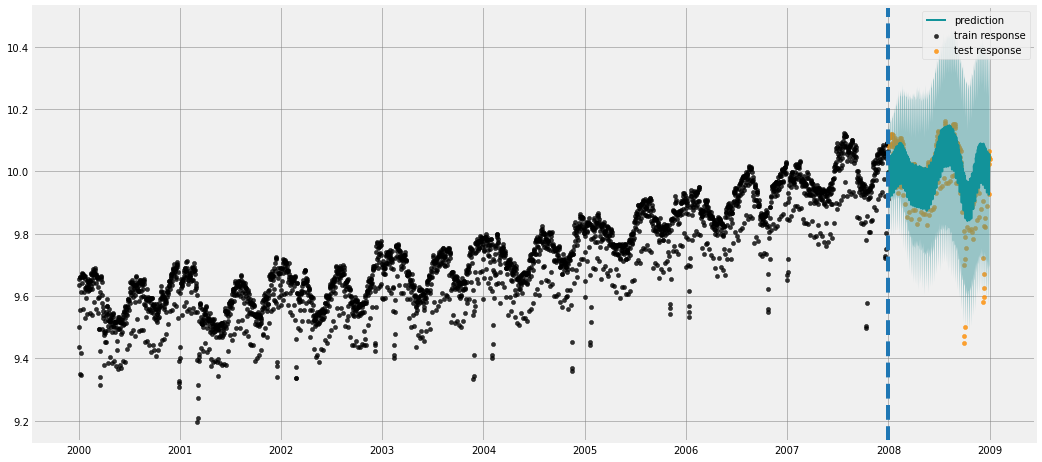

In [32]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col, 
                    test_actual_df=test_df)